<h2> Content-based filtering recommendation system based on the summary of a book </h2>

In [122]:
from IPython.display import Image
Image(url='https://media.giphy.com/media/SiMcadhDEZDm93GmTL/giphy.gif')

In [123]:
Image(url='https://media.giphy.com/media/5CneX2xXm7fUI/giphy.gif')

<h3> Introduction </h3>  
In this notebook, we will investigate whether the summary of a book can effectively recommend similar books. We will be using Google's NLP model (BERT) to analyse the summary of every book and calculate the cosine similarity between each book. We will then recommend the top 5 most similar books based on the higest cosine similarity.

In [ ]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.2 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=1375d34397b89f6700b702ffdf816abb33cee171eb08b3bb7a1e6ca0b796b3ac
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

In [66]:
data = pd.read_csv('Processed_Book_Data.csv')

# Remove rows with digits in the summary column
data = data[data['Summary'].str.isdigit() == False]
data = data[data['Category'].str.isdigit() == False]

# Drop duplicate books
data = data.drop_duplicates(subset=['isbn'])
data.shape


(138701, 11)

In [67]:
# Randomly sample 15% of data (20k) to reduce computation time
data = data.sample(frac=0.15).reset_index(drop=True)
data.shape


(20805, 11)

In [68]:
X = np.array(data.Summary)
data.rename(columns={'book_title':'Book Title'}, inplace=True)
data = data[['Category','Summary','Book Title', 'img_l']]
data.head()

Category                                            Summary  \
0              ['Fiction']  Marina Meredith goes to Cornwall to heal after...   
1             ['Colombia']  Un hombre regresa al pueblo donde ocurri un as...   
2              ['Fiction']  While an independent young woman struggles wit...   
3  ['Juvenile Nonfiction']  Offers an inside look into how a mosque was bu...   
4              ['Fiction']  In his attempts to solve three perplexing murd...   

                                          Book Title  \
0                                    Light in Summer   
1                    Cronica De Una Muerte Anunciada   
2                                        Babel Tower   
3                                             Mosque   
4  Murder in Canton : A Judge Dee Mystery (Gulik,...   

                                               img_l  
0  http://images.amazon.com/images/P/0312054629.0...  
1  http://images.amazon.com/images/P/9500704285.0...  
2  http://images.amazon.com/images/P/0679405135.0...  
3  http://images.amazon.com/images/P/0618240349.0...  
4  http://images.amazon.com/images/P/0226848744.0...

In [69]:
text_data = X
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(text_data, show_progress_bar=True)

Batches:   0%|          | 0/651 [00:00<?, ?it/s]

<h1> Principal Components Analysis </h1>
We are using Principal Components Analysis to reduce the dimensionality of our dataset. It is so that we can represent our data in a vector form for data manipulatio. The values below gives an idea of the result of the text-vector conversion.

In [70]:
X = np.array(embeddings)
n_comp = 5
pca = PCA(n_components=n_comp)
pca.fit(X)
pca_data = pd.DataFrame(pca.transform(X))
pca_data.head()

0         1         2         3         4
0 -4.878726 -3.124883  0.296173  3.939444 -2.103873
1  5.095684  5.798203  6.737351  1.009961  0.712099
2 -3.676132 -1.358974 -2.303367  6.587889  1.959986
3  3.993323  3.206466  1.460531 -2.609286 -1.376766
4 -4.169234  3.786508  0.275338 -3.049067 -2.659640

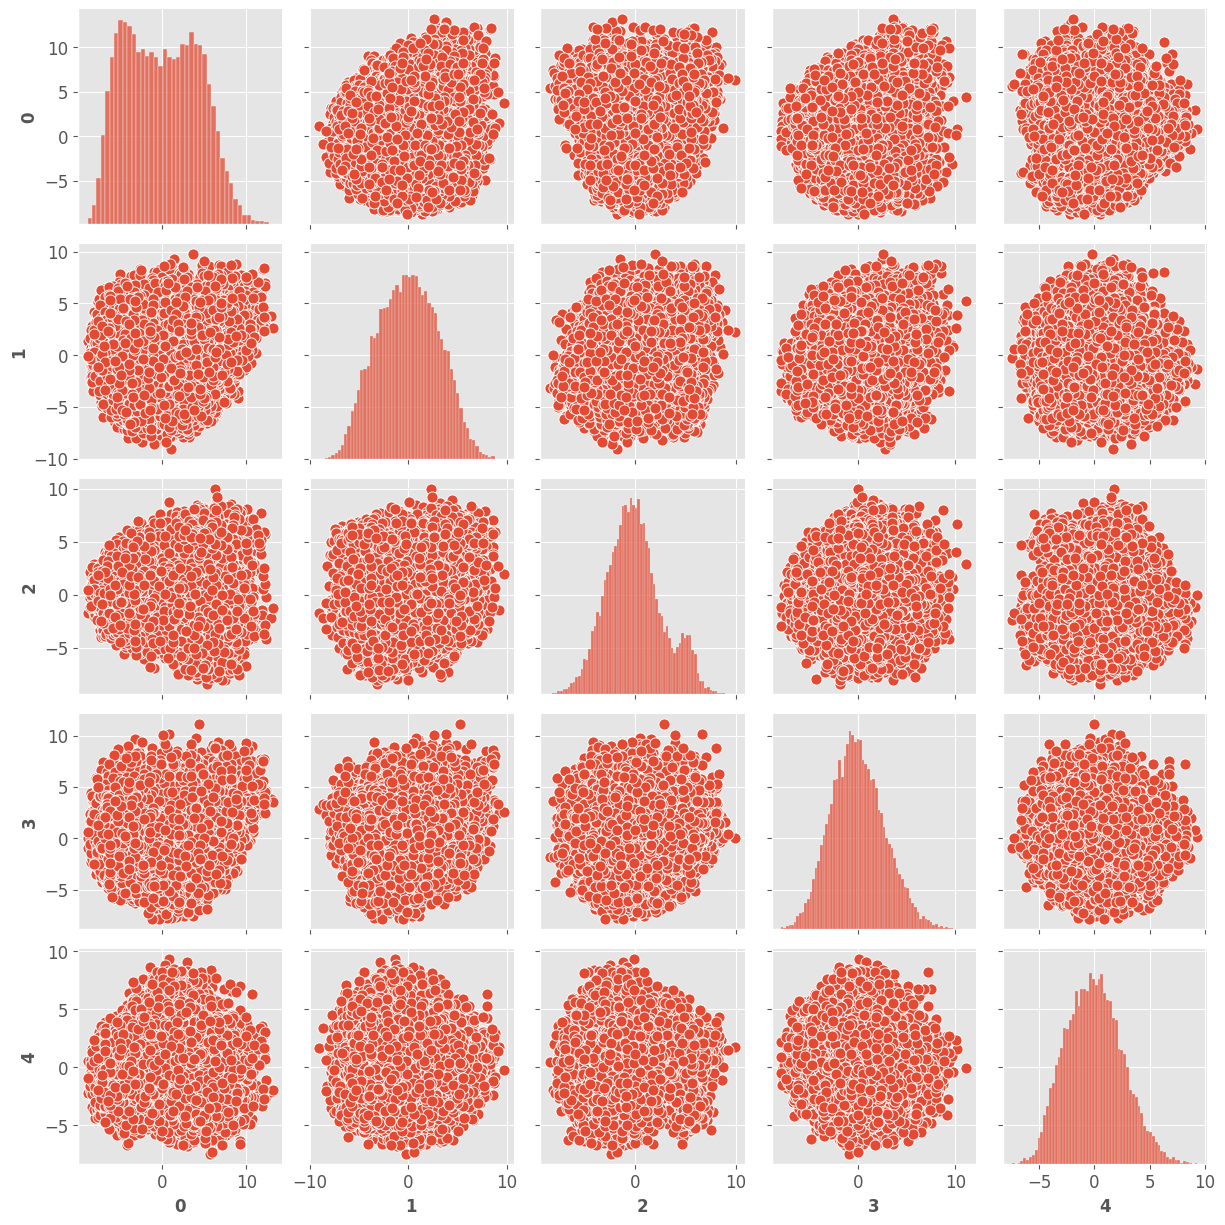

In [71]:
sns.pairplot(pca_data)

Calculation of cosine similarity

In [72]:
cos_sim_data = pd.DataFrame(cosine_similarity(X))

In [73]:
cos_sim_data.loc[2].sort_values(ascending=False)[1:6].tolist()

C:\Users\tengwei\AppData\Local\Temp\ipykernel_4204\2737284647.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  cos_sim_data.loc[2].sort_values(ascending=False)[1:6].tolist()


[0.8508555293083191,
 0.8437454700469971,
 0.8349924683570862,
 0.8330169916152954,
 0.831881046295166]

But why do we want to convert texts into vectors in the first place?

Well, because now that we have vectors we are able to do all the operations that you usually do on vectors :)

Imagine you are doing a classification task and you want to use Support Vector Machines. Well, of course, you will need to have vectors to do that. So if you have to classify a text you will first convert the text into a vector and then apply the SVM algorithm.

In our case we will use the vectorize test to find the similarity between two vectors. Our recommendation will be the (5) most similar vectors with the one we are considering.

This is an image explaining cosine similarity, courtesy of our lecture notes.
The closer the angle between the two vectors, the higher the cosine similarity, the more similar they are.
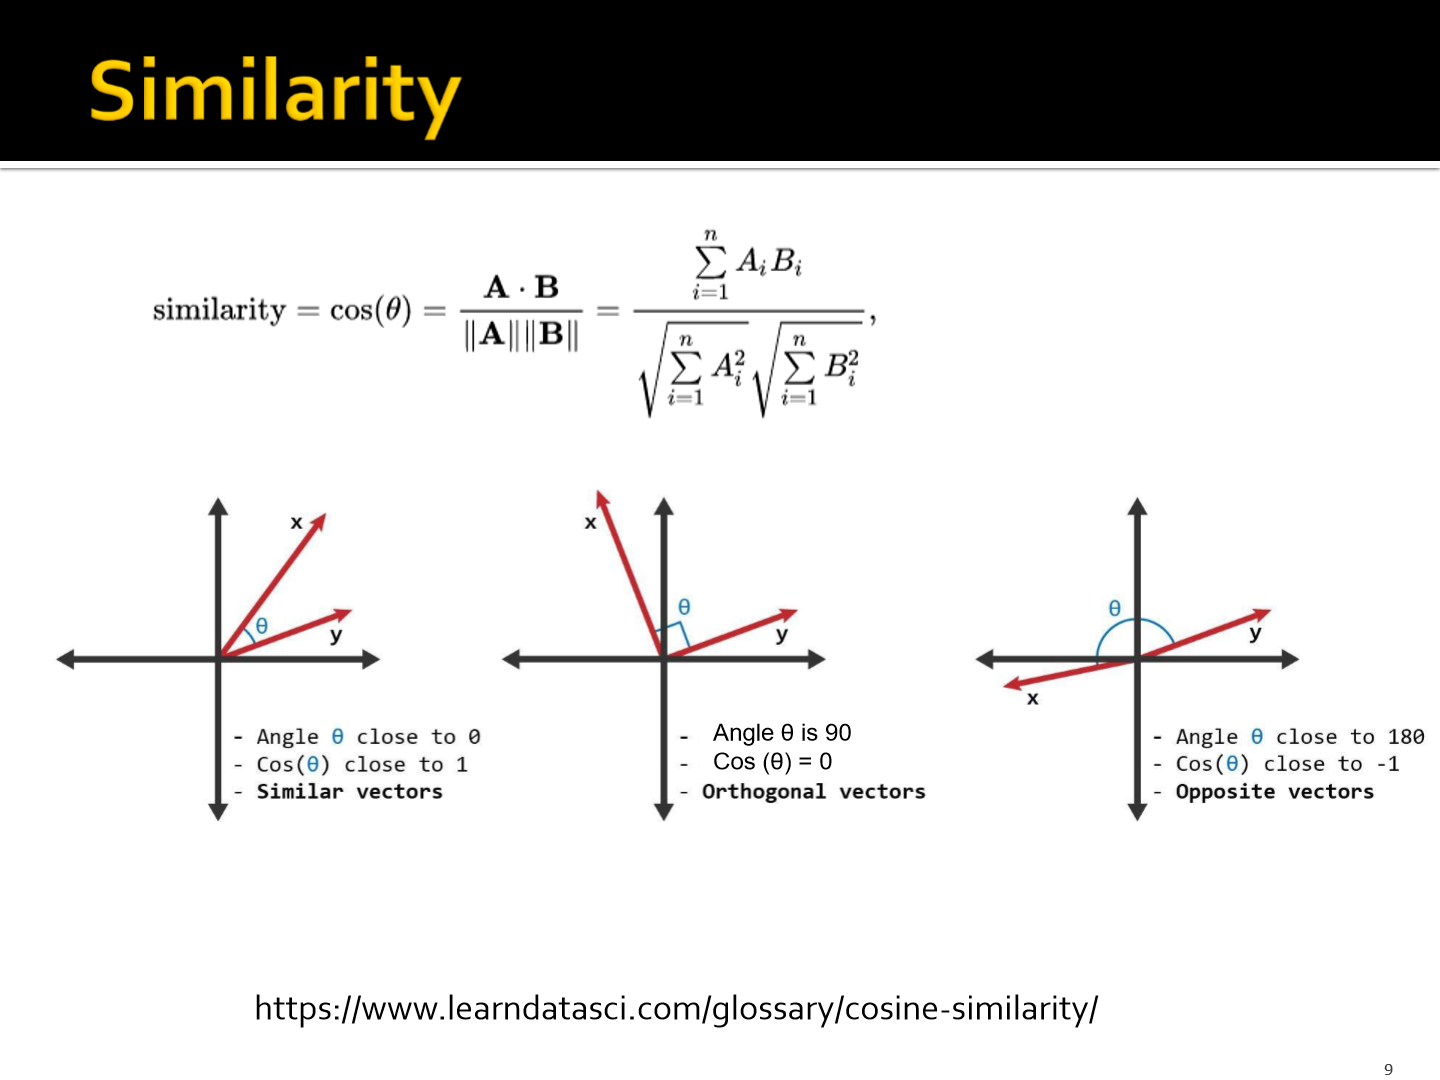

Let’s say x and y are two components (we’ll have way more than two). If a book talks about adventures, monsters and heroes and another one talks more or less about the same stuff, we expect the two vectors to be close (smaller angle between the two vectors).
On the other hand, if the other book is about a love story we will expect this vector to be far away (larger angle between the two vectors).

So here is what we’ll do:

1. Use BERT to convert our text into a vector  
2. Get the cosine similarity (the cosine of the angle between the two vectors) of a fixed book (vector) and all the other ones  
3. Pick the books (vectors) with the largest cosine similarity. We are going to pick 5 of them.  

Function to give books recommendations

In [109]:
from PIL import Image
import requests
from io import BytesIO

def give_recommendations(index, print_recommendation = False, print_recommendation_summary = False, print_categories = False, show_book_cover=False):
  index_recomm = cos_sim_data.loc[index].sort_values(ascending=False).index.tolist()[1:6]
  cosine_values = cos_sim_data.loc[index].sort_values(ascending=False).tolist()[1:6]
  books_recomm =  data['Book Title'].loc[index_recomm].values
  result = {'Books':books_recomm,'Index':index_recomm}
  k=0

  if print_recommendation==True:
    print('The book read: %s \n'%(data['Book Title'].loc[index]))
    for book in books_recomm:
      print('The number %i recommended book (cosine similarity= %s): %s \n'%(k, cosine_values[k], book))
      k += 1

  if print_recommendation_summary==True:
    print('The summary of the book read (%s):\n %s \n' %(data['Book Title'].loc[index], data['Summary'].loc[index]))
    k=0
    for q in range(len(books_recomm)):
      plot_q = data['Summary'].loc[index_recomm[q]]
      print('The summary of the number %i recommended book (%s):\n %s \n'%(k, books_recomm[k], plot_q))
      k=k+1

  if print_categories==True:
    print('The categories of the book read:\n %s \n'%(data['Category'].loc[index]))
    k=0
    for q in range(len(books_recomm)):
      plot_q = data['Category'].loc[index_recomm[q]]
      print('The categories of the number %i recommended book (%s):\n %s \n'%(k, books_recomm[k], plot_q))
      k=k+1
  
  if show_book_cover==True:
    fig, axs = plt.subplots(1, 5,figsize=(18,5))
    fig.suptitle('You may also like these books', size = 22)
    for i in range(len(books_recomm)):
        url = data['img_l'].loc[index_recomm[i]]
        headers ={'User-Agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.114 Safari/537.36'}
        response = requests.get(url, headers=headers)
        im = Image.open(BytesIO(response.content))
        axs[i].imshow(im)
        axs[i].axis("off")
        axs[i].set_title('Cosine Similarity: {}'.format(round(cosine_values[i],2)), size = 10, y=-0.18,color="red",fontsize=18)
        fig.show()

  return result

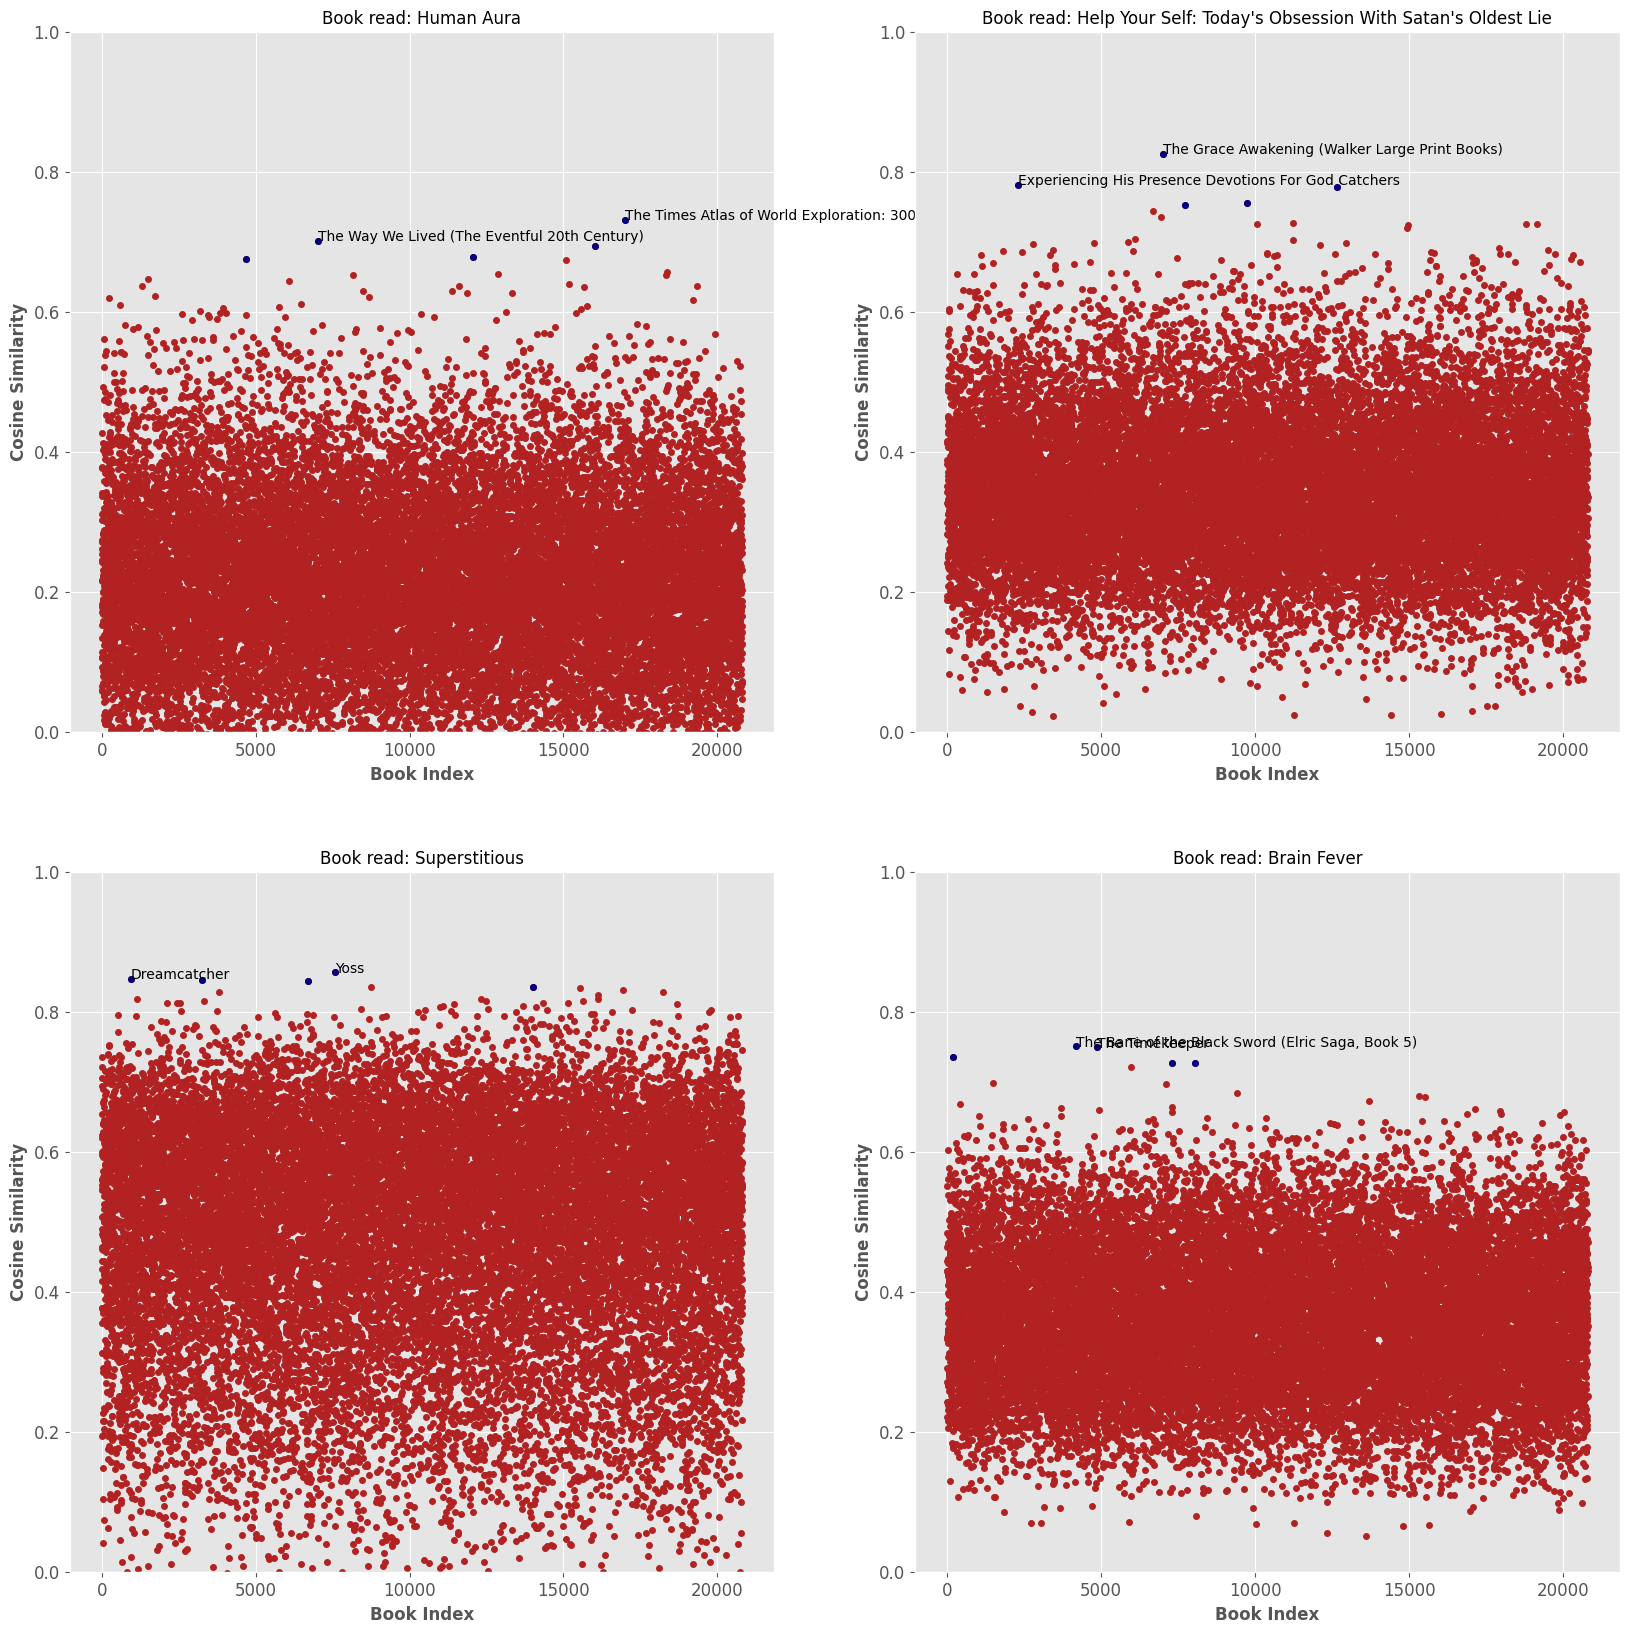

In [90]:
plt.figure(figsize=(20,20))
for q in range(1,5):
  plt.subplot(2,2,q)
  # Randomly choosing a book
  index = np.random.choice(np.arange(0,len(X)))
  to_plot_data = cos_sim_data.drop(index,axis=1)
  plt.plot(to_plot_data.loc[index],'.',color='firebrick')
  recomm_index = give_recommendations(index)
  x = recomm_index['Index']
  y = cos_sim_data.loc[index][x].tolist()
  m = recomm_index['Books']
  plt.plot(x,y,'.',color='navy',label='Recommended books')
  plt.title('Book read: '+data['Book Title'].loc[index])
  plt.xlabel('Book Index')
  k=0
  for x_i in x[:2]:
    plt.annotate('%s'%(m[k]),(x_i,y[k]),fontsize=10)
    k=k+1

  plt.ylabel('Cosine Similarity')
  plt.ylim(0,1)

The book read: The Ultimate Personality Guide 

The number 0 recommended book (cosine similarity= 0.7630428075790405): India: Belief and Ritual the Gods and Cosmos Meditation and Yogic Arts 

The number 1 recommended book (cosine similarity= 0.7453652620315552): Praying for Rain: Timothy Findley's Not Wanted on the Voyage (Canadian Fiction Studies, No. 21) 

The number 2 recommended book (cosine similarity= 0.7397469878196716): Writings of Jonathan Swift (Norton Critical Edition) 

The number 3 recommended book (cosine similarity= 0.7393631935119629): Harley Hahn's Student Guide To Unix 

The number 4 recommended book (cosine similarity= 0.7380564212799072): The Astrologer's Handbook 



C:\Users\tengwei\AppData\Local\Temp\ipykernel_4204\4261440742.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'Books': array(['India: Belief and Ritual the Gods and Cosmos Meditation and Yogic Arts',
        "Praying for Rain: Timothy Findley's Not Wanted on the Voyage (Canadian Fiction Studies, No. 21)",
        'Writings of Jonathan Swift (Norton Critical Edition)',
        "Harley Hahn's Student Guide To Unix", "The Astrologer's Handbook"],
       dtype=object),
 'Index': [1535, 11685, 3607, 4843, 13741]}

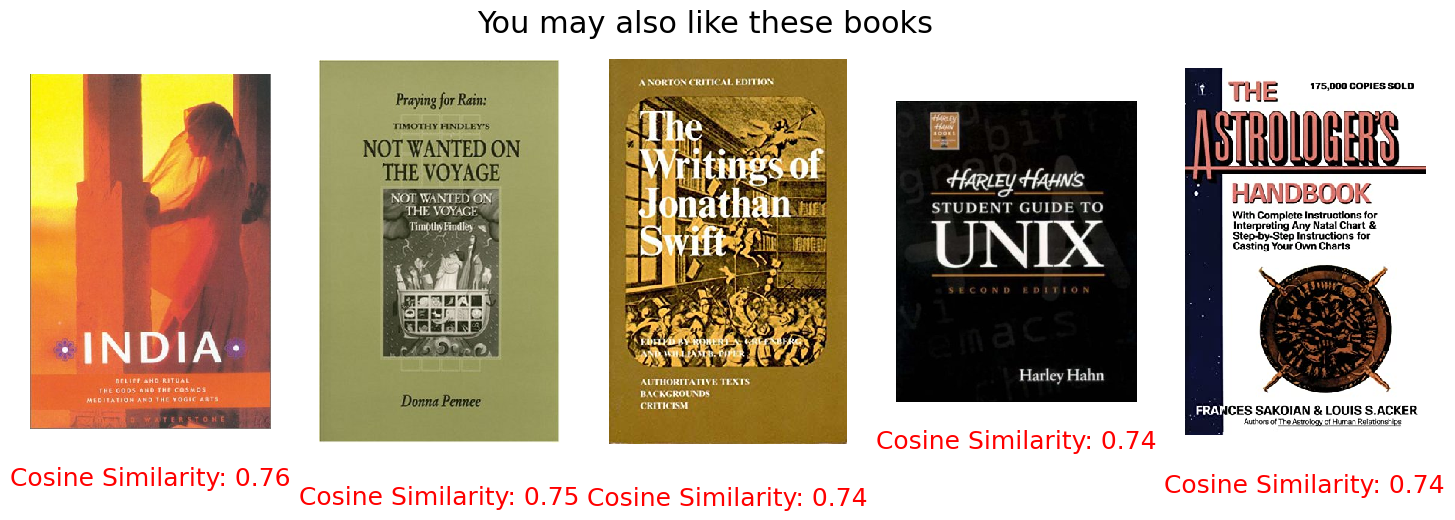

In [96]:
give_recommendations(8,True, show_book_cover=True)

The summary of the book read (Young Adam):
 When a drifter discovers the corpse of young woman while traveling on
a barge on the Clyde River, he soon finds himself a suspect in the
subsequent murder investigation. OReprint. 

The summary of the number 0 recommended book (The Red Sky File):
 District Marshall Ty Merrick and her partner are called in when a
mysterious killer begins to prey on the crewmembers of the river
cutter Delora, and she must find the evil force that lurks in the
toxic waters of the Black River. 

The summary of the number 1 recommended book (A Deep Blue Farewell (Scotia MacKinnon Mysteries)):
 Pacific Northwest private detective Scotia MacKinnon is hired by the
victim&#39;s brother to investigate the &quot;accidental&quot; death
of Tina Breckenridge, a sailing instructor, who supposedly drowned
near her abandoned boat, following a trail of ... 

The summary of the number 2 recommended book (Under Cover of Daylight):
 Years after his real parents are killed by a dr

C:\Users\tengwei\AppData\Local\Temp\ipykernel_4204\4261440742.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'Books': array(['The Red Sky File',
        'A Deep Blue Farewell (Scotia MacKinnon Mysteries)',
        'Under Cover of Daylight', 'The Deadliest of Friends', 'Sunflower'],
       dtype=object),
 'Index': [2009, 3095, 9294, 5509, 575]}

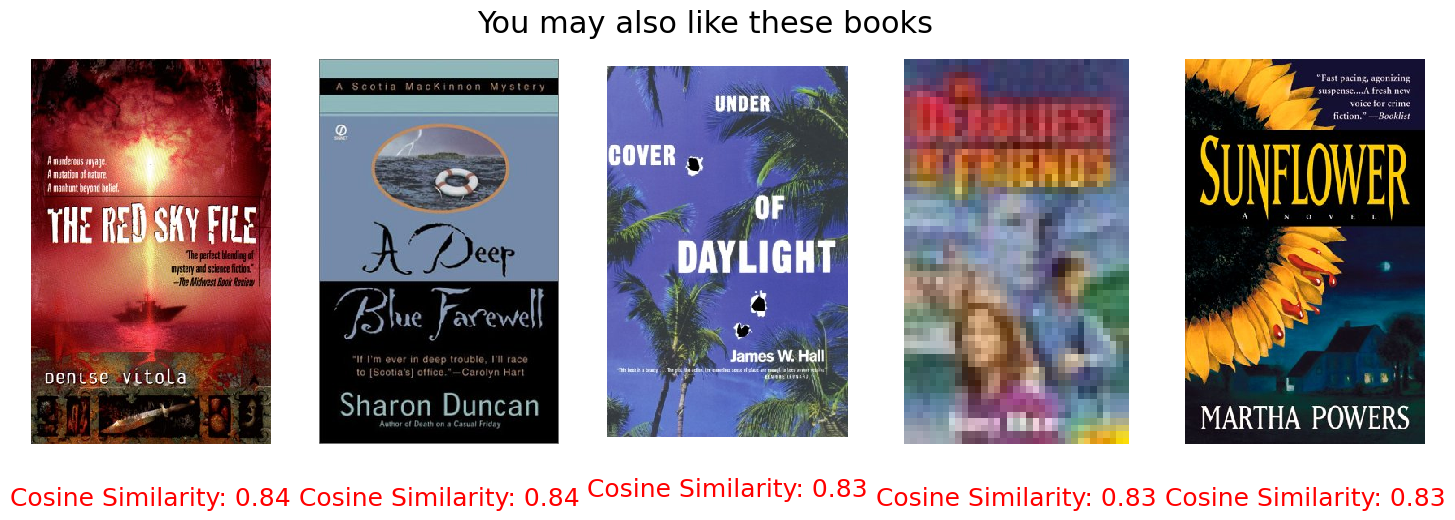

In [104]:
give_recommendations(15,False,True, show_book_cover=True)

The book read: Discourse on Thinking 

The number 0 recommended book (cosine similarity= 0.7186868190765381): Inner Experience (Suny Series : Intersections : Philosophy and Critical Theory) 

The number 1 recommended book (cosine similarity= 0.6949324607849121): Unconditional Love: Love Without Limits 

The number 2 recommended book (cosine similarity= 0.6916741132736206): The Power of Intention: Learning to Co-Create Your World Your Way 

The number 3 recommended book (cosine similarity= 0.6800311803817749): Sunrise on Stradbury Square (Fell, Doris Elaine. Sagas of a Kindred Heart, Bk. 3.) 

The number 4 recommended book (cosine similarity= 0.6701380014419556): TIMING IS EVERYTHING : TIMING IS EVERYTHING 

The summary of the book read (Discourse on Thinking):
 Discourse on Thinking questions that must occur to us the moment we
manage to see a familiar situation in unfamiliar light. 

The summary of the number 0 recommended book (Inner Experience (Suny Series : Intersections : Philosop

C:\Users\tengwei\AppData\Local\Temp\ipykernel_4204\3209618917.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'Books': array(['Inner Experience (Suny Series : Intersections : Philosophy and Critical Theory)',
        'Unconditional Love: Love Without Limits',
        'The Power of Intention: Learning to Co-Create Your World Your Way',
        'Sunrise on Stradbury Square (Fell, Doris Elaine. Sagas of a Kindred Heart, Bk. 3.)',
        'TIMING IS EVERYTHING : TIMING IS EVERYTHING'], dtype=object),
 'Index': [13483, 17664, 990, 9114, 15615]}

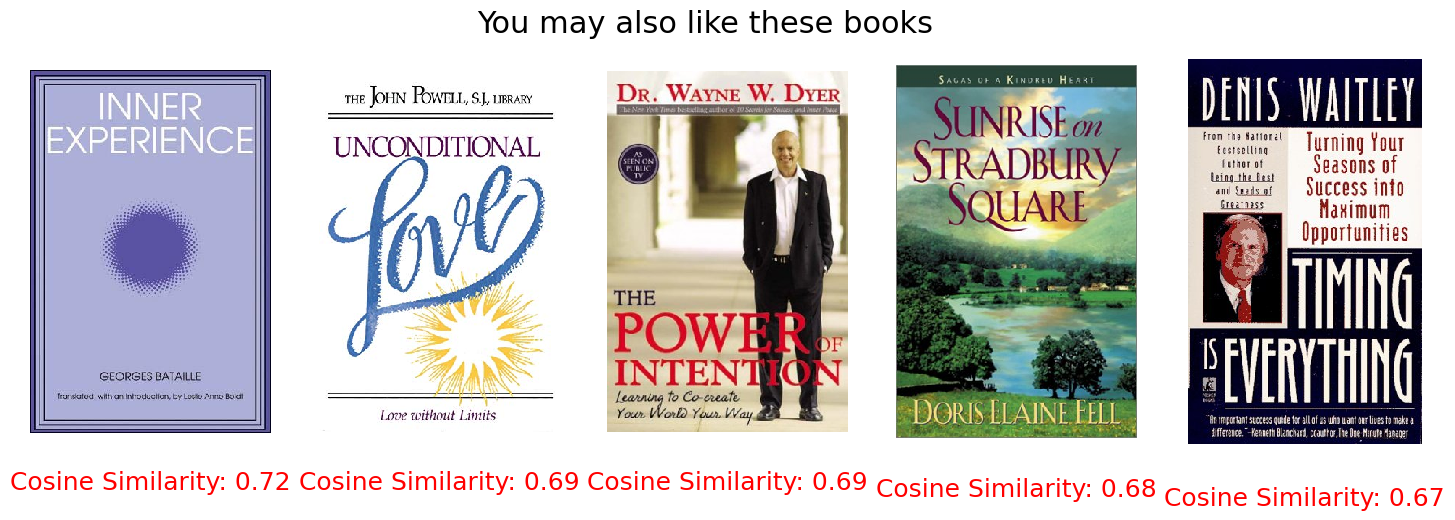

In [111]:
give_recommendations(27,True,True,True,True)

Storing our top 5 generated book recommendation for every book into a dataframe

In [112]:
recomm_list = []
for i in range(len(X)):
  recomm_i = give_recommendations(i)
  recomm_list.append(recomm_i['Books'])
recomm_data = pd.DataFrame(recomm_list,columns=['First Recommendation','Second Recommendation','Third Recommendation','Fourth Recommendation','Fifth Recommendation'])
recomm_data['Book read'] = data['Book Title']
recomm_data = recomm_data[['Book read','First Recommendation','Second Recommendation','Third Recommendation','Fourth Recommendation','Fifth Recommendation']]

In [113]:
recomm_data.sample(frac=1).head()

Book read  \
14940  The Complete Guide to Coffee Grounds & Tea Lea...   
17964                                The Victorian album   
4207                                        Lost Chicago   
12913                               Prisoner of Vampires   
4470                              Jerry Lewis: In Person   

                                First Recommendation  \
14940                        What Makes Nature Tick?   
17964           The Secret Diary of Katie Dinkerhoff   
4207     Chicago and the American Century (Illinois)   
12913  Shutterbug Follies (Doubleday Graphic Novels)   
4470            Hollywood Handbook : Chateau Marmont   

                                   Second Recommendation  \
14940                         Linda Goodman's Star Signs   
17964  The Mystery of the Cupboard (Indian in the Cup...   
4207   New Orleans : A Picture Book To Remember Her B...   
12913                   Daredevil: The Man With Out Fear   
4470                       Photodiary: A Musical Journey   

                                    Third Recommendation  \
14940                                   La magia rÃºnica   
17964                                 The Little Country   
4207   Milking the Moon : A Southerner's Story of Lif...   
12913             Murder on Gramercy Park (Sarah Brandt)   
4470                                      A God in Ruins   

                                   Fourth Recommendation  \
14940  Llewellyn's 2003 Sun Sign Book (Llewellyns Sun...   
17964                                 Out of the Shadows   
4207     Murder in Minnesota: A Collection of True Cases   
12913                                   Murder Is Served   
4470   Exploring the Matrix: Visions of the Cyber Future   

                                    Fifth Recommendation  
14940                                Intangible Evidence  
17964           Anne Frank's Tales from the Secret Annex  
4207   Ernie Harwell: My 60 Years in Baseball (Honori...  
12913  Watch Out, Man Eating Snake (New Kids at the P...  
4470   Volleyball With the Cuna Indians: And Other Ga...